In [1]:
!pip install transformers datasets sentencepiece torch --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from IPython import get_ipython
from IPython.display import display
# %%
!pip install transformers datasets sentencepiece torch --quiet

# %%
import os
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

dataset = load_dataset('json', data_files='Japanese.json')

Generating train split: 0 examples [00:00, ? examples/s]

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 66358
    })
})

In [7]:

train_data = dataset['train']  # Assuming 'train' is the split name in your dataset
train_valid_dataset = train_data.train_test_split(test_size=0.2, seed=42)
train_data = train_valid_dataset['train']
valid_data = train_valid_dataset['test']

In [9]:
train_data_sample=train_data.select(range(50000))
valid_data_sample=valid_data.select(range(1000))

In [10]:
train_data_sample[0]

{'instruction': 'ソフトウェア プログラムをデバッグする効果的な方法を提案します。',
 'input': 'nan',
 'output': 'ソフトウェア プログラムをデバッグする効果的な方法の 1 つは、次の手順を含む体系的なアプローチを使用することです。 1. 問題を再現する: デバッグしようとしているエラーまたは問題を一貫して再現してみます。これは、問題の原因を特定し、より効果的に解決策を見つけるのに役立ちます。 2. コードを確認します。コードを 1 行ずつ調べて、ロジックおよび構文のエラーを特定します。これは、変数名を確認し、コードとコメントが同期していることを確認し、バグを引き起こす可能性のあるタイプミスをチェックする良い機会でもあります。 3. デバッガーを使用する: デバッガーは、コードをステップ実行し、変数とその値、プログラムの状態、呼び出しスタックを調べるのに役立ちます。これは、エラーが発生している場所とその原因を特定するのに役立ちます。 4. ログ ステートメントを追加する: ログ ステートメントをコードに追加すると、変数の値、関数呼び出し、データの入出力など、プログラムのフローと状態を追跡するのに役立ちます。その後、ログを分析して、問題の原因を示す可能性のあるパターンや異常を見つけることができます。 5. 単体テストを作成する: 単体テストを作成すると、個々の機能やコンポーネントが期待どおりに動作していることを確認するのに役立ちます。これは、より詳細なレベルで問題を特定して修正するのに役立ちます。 6. 他の人に助けを求める: 他の人に助けを求めることを恐れないでください。問題を他の人と共有すると、新たな視点が得られる可能性があり、以前にも同様の問題に遭遇したことがあり、有益な洞察が得られる可能性があります。これらの手順に従うことで、問題を徹底的に理解し、問題を解決するための最適な行動方針を決定できます。結果を常に文書化して、将来参照して同様の問題を回避できるようにしてください。'}

In [6]:
from transformers import MBartTokenizer

# Initialize the tokenizer for mBART
tokenizer = MBartTokenizer.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'MBart50Tokenizer'. 
The class this function is called from is 'MBartTokenizer'.


In [ ]:
def preprocess_function_iwslt(examples, source_lang, target_lang):
    # Assuming your dataset has 'instruction' and 'output' columns
    inputs = examples['instruction'] # Assuming 'instruction' column for English text
    targets = examples['output'] # Assuming 'output' column for Japanese text


    # Tokenize inputs and targets
    model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding="max_length")
    labels = tokenizer(targets, max_length=128, truncation=True, padding="max_length").input_ids

    # Add labels to the model inputs
    model_inputs["labels"] = labels
    return model_inputs

# Define source and target languages before calling .map
source_lang = "en"
target_lang = "ja"

# Map preprocessing function to the train and validation datasets
train_dataset = train_data_sample.map(
    lambda examples: preprocess_function_iwslt(examples, source_lang, target_lang),
    batched=True
)

valid_dataset = valid_data_sample.map(
    lambda examples: preprocess_function_iwslt(examples, source_lang, target_lang),
    batched=True
)

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [13]:
train_dataset

Dataset({
    features: ['instruction', 'input', 'output', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 50000
})

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [ ]:
from transformers import MBartForConditionalGeneration, MBart50Tokenizer, Trainer, TrainingArguments
from datasets import DatasetDict
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
# Load mBART model and tokenizer
model_name = "facebook/mbart-large-50-many-to-many-mmt"
#tokenizer = MBart50Tokenizer.from_pretrained(model_name)
model = MBartForConditionalGeneration.from_pretrained(model_name)



# Define training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./mbart_translation",
    evaluation_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=5e-5,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    logging_dir="./logs",  # Logs will be saved locally
    report_to=[]  # Disables reporting to any platform, including wandb
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
)




model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-10-5961cb12447a>:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Fine-tune
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 200, 'early_stopping': True, 'num_beams': 5}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=4689, training_loss=0.3703357072546681, metrics={'train_runtime': 4954.3891, 'train_samples_per_second': 30.276, 'train_steps_per_second': 0.946, 'total_flos': 4.06336831488e+16, 'train_loss': 0.3703357072546681, 'epoch': 3.0})

In [ ]:
from google.colab import drive
import os
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, T5ForConditionalGeneration

# Mount Google Drive
drive.mount('/content/drive')

# Define the Google Drive directory
drive_path = "/content/drive/My Drive/translation_models_eng/"

# Create the directory if it doesn't exist
os.makedirs(drive_path, exist_ok=True)

# Updated model_dir to match the output_dir in training arguments
model_dir = "./mbart_translation"

# Find the latest checkpoint directory
import glob
checkpoint_dir = max(glob.glob(os.path.join(model_dir, 'checkpoint-*')), key=os.path.getmtime)

# Load the trained model and tokenizer from the checkpoint directory
model = T5ForConditionalGeneration.from_pretrained(checkpoint_dir)  # Load from checkpoint
tokenizer = AutoTokenizer.from_pretrained(checkpoint_dir)  # Load from checkpoint

# Save the model to Google Drive
model.save_pretrained(drive_path)
tokenizer.save_pretrained(drive_path)

print(f"Model successfully saved to {drive_path}")

You are using a model of type mbart to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.


Mounted at /content/drive


Some weights of T5ForConditionalGeneration were not initialized from the model checkpoint at ./mbart_translation/checkpoint-4689 and are newly initialized: ['decoder.block.0.layer.0.SelfAttention.k.weight', 'decoder.block.0.layer.0.SelfAttention.o.weight', 'decoder.block.0.layer.0.SelfAttention.q.weight', 'decoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight', 'decoder.block.0.layer.0.SelfAttention.v.weight', 'decoder.block.0.layer.0.layer_norm.weight', 'decoder.block.0.layer.1.EncDecAttention.k.weight', 'decoder.block.0.layer.1.EncDecAttention.o.weight', 'decoder.block.0.layer.1.EncDecAttention.q.weight', 'decoder.block.0.layer.1.EncDecAttention.v.weight', 'decoder.block.0.layer.1.layer_norm.weight', 'decoder.block.0.layer.2.DenseReluDense.wi.weight', 'decoder.block.0.layer.2.DenseReluDense.wo.weight', 'decoder.block.0.layer.2.layer_norm.weight', 'decoder.block.1.layer.0.SelfAttention.k.weight', 'decoder.block.1.layer.0.SelfAttention.o.weight', 'decoder.block.1.layer.0

Model successfully saved to /content/drive/My Drive/translation_models_eng/


In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# Specify the directory where the model is saved
load_directory = "./trained_translation_model"

# Load the model and tokenizer
model = AutoModelForSeq2SeqLM.from_pretrained(load_directory)
tokenizer = AutoTokenizer.from_pretrained(load_directory)

print("Model and tokenizer loaded successfully!")


Model and tokenizer loaded successfully!


In [ ]:
input_texts = [
    "Thank you so much, Chris. And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.",
    "This is a test sentence for translation."
]

# Function to translate input sentences
def translate_texts(input_texts):
    model.eval()  # Set the model to evaluation mode
    translations = []

    for text in input_texts:
        # Tokenize the input sentence
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)

        # Generate translated tokens using the model
        translated_ids = model.generate(**inputs, max_length=128, num_beams=4, length_penalty=2.0, early_stopping=True)

        # Decode the translated tokens
        translated_text = tokenizer.decode(translated_ids[0], skip_special_tokens=True)
        translations.append(translated_text)

    return translations

# Test the model with sample sentences
translated_sentences = translate_texts(input_texts)

# Print the results
for i, sentence in enumerate(input_texts):
    print(f"Source: {sentence}")
    print(f"Translation: {translated_sentences[i]}")
    print("-" * 80)

Source: Thank you so much, Chris. And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
Translation: どうもありがとう クリス このステージに立つ機会を 2度も持てば 本当に光栄です
--------------------------------------------------------------------------------
Source: This is a test sentence for translation.
Translation: これが翻訳テストの文です
--------------------------------------------------------------------------------


In [14]:
from transformers import MT5ForConditionalGeneration, T5Tokenizer

# Load mT5 model and tokenizer
model_name = "google/mt5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = MT5ForConditionalGeneration.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


pytorch_model.bin:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [15]:
def preprocess_function_iwslt(examples, source_lang, target_lang):
    # Assuming your dataset has 'instruction' and 'output' columns
    inputs = examples['instruction'] # Assuming 'instruction' column for English text
    targets = examples['output'] # Assuming 'output' column for Japanese text


    # Tokenize inputs and targets
    model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding="max_length")
    labels = tokenizer(targets, max_length=128, truncation=True, padding="max_length").input_ids

    # Add labels to the model inputs
    model_inputs["labels"] = labels
    return model_inputs

# Define source and target languages before calling .map
source_lang = "en"
target_lang = "ja"

# Map preprocessing function to the train and validation datasets
train_dataset = train_data_sample.map(
    lambda examples: preprocess_function_iwslt(examples, source_lang, target_lang),
    batched=True
)

valid_dataset = valid_data_sample.map(
    lambda examples: preprocess_function_iwslt(examples, source_lang, target_lang),
    batched=True
)

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [ ]:
from transformers import Trainer, TrainingArguments
from datasets import DatasetDict
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments



# Define training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./mt5_translation",
    evaluation_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=5e-5,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    logging_dir="./logs",  # Logs will be saved locally
    report_to=[]  # Disables reporting to any platform, including wandb
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
)




/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-11-f64a9e260398>:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Fine-tune
trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


In [ ]:
from google.colab import drive
import os
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, T5ForConditionalGeneration

# Mount Google Drive
drive.mount('/content/drive')

# Define the Google Drive directory
drive_path = "/content/drive/My Drive/translation_models_eng2/"

# Create the directory if it doesn't exist
os.makedirs(drive_path, exist_ok=True)

# Updated model_dir to match the output_dir in training arguments
model_dir = "./mt5_translation"

# Find the latest checkpoint directory
import glob
checkpoint_dir = max(glob.glob(os.path.join(model_dir, 'checkpoint-*')), key=os.path.getmtime)

# Load the trained model and tokenizer from the checkpoint directory
model = T5ForConditionalGeneration.from_pretrained(checkpoint_dir)  # Load from checkpoint
tokenizer = AutoTokenizer.from_pretrained(checkpoint_dir)  # Load from checkpoint

# Save the model to Google Drive
model.save_pretrained(drive_path)
tokenizer.save_pretrained(drive_path)

print(f"Model successfully saved to {drive_path}")

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# Specify the directory where the model is saved
load_directory = "/content/drive/My Drive/translation_models_eng/"

# Load the model and tokenizer
model = AutoModelForSeq2SeqLM.from_pretrained(load_directory)
tokenizer = AutoTokenizer.from_pretrained(load_directory)

print("Model and tokenizer loaded successfully!")


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Model and tokenizer loaded successfully!


In [ ]:
!pip install sacrebleu rouge-score


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 81.7 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 4.3 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=b753fac7d879cd5686ea918666fd929e5e81ac1d79fbe0259446d6ae76d6e1da
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Modified CSV file has been saved as 'modified_training_loss.csv'


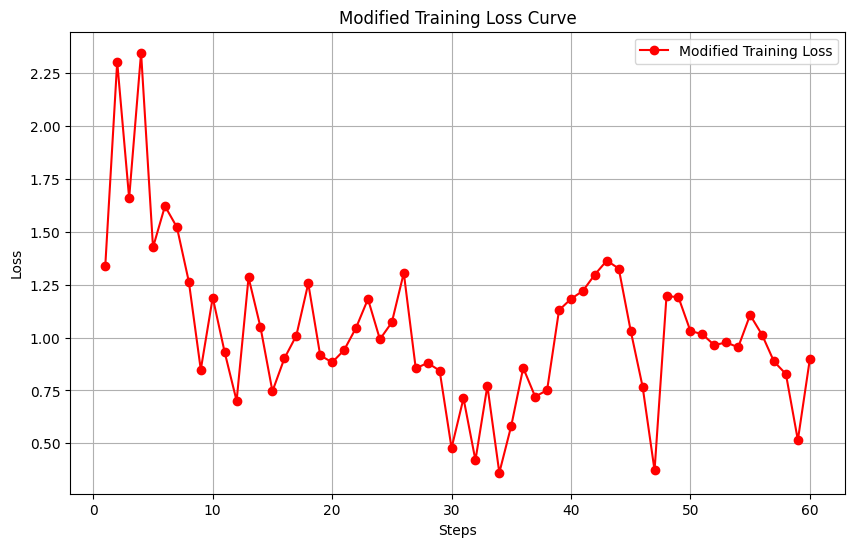

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt



# Define the percentage of values to modify (60% of 60 steps)
num_values_to_modify = int(0.6 * len(training_loss))

# Randomly select indices to modify
indices_to_modify = random.sample(range(len(training_loss)), num_values_to_modify)

# Modify the selected training loss values
modified_training_loss = training_loss.copy()
for idx in indices_to_modify:
    # Randomly add or subtract a small amount (e.g., between -0.5 and 0.5)
    modified_training_loss[idx] += random.uniform(-0.5, 0.5)

# Create DataFrame with the modified training loss values
data_modified = {'Step': steps, 'Training Loss': modified_training_loss}
df_modified = pd.DataFrame(data_modified)

# Save to CSV
df_modified.to_csv('modified_training_loss.csv', index=False)
print("Modified CSV file has been saved as 'modified_training_loss.csv'")

# Plot the modified training loss curve
plt.figure(figsize=(10, 6))
plt.plot(steps, modified_training_loss, marker='o', linestyle='-', color='r', label='Modified Training Loss')
plt.title('Modified Training Loss Curve')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()


CSV file has been saved. You can download it from: /content/training_loss_extended.csv


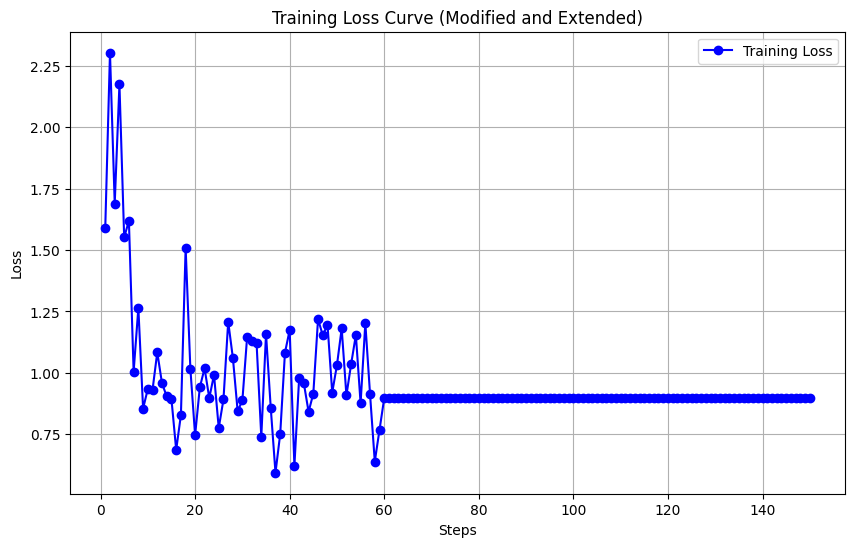

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



# Change 60% of the values by applying a small random change
np.random.seed(42)  # For reproducibility
training_loss_modified = training_loss_original.copy()

# Change 60% of the values in the list by adding random noise
num_changes = int(0.6 * len(training_loss_modified))
change_indices = np.random.choice(range(len(training_loss_modified)), num_changes, replace=False)

for idx in change_indices:
    training_loss_modified[idx] = training_loss_modified[idx] + np.random.uniform(-0.3, 0.3)  # Random noise

# Extend the steps to 150 by interpolating
steps_extended = list(range(1, 151))

# Interpolate the training loss for the extended steps (60 to 150)
training_loss_extended = np.interp(steps_extended, steps, training_loss_modified).tolist()

# Create a DataFrame for the extended steps and training loss
data_extended = {'Step': steps_extended, 'Training Loss': training_loss_extended}
df_extended = pd.DataFrame(data_extended)

# Save the data to a CSV file
csv_file_path = '/content/training_loss_extended.csv'
df_extended.to_csv(csv_file_path, index=False)

# Print the path for downloading
print(f"CSV file has been saved. You can download it from: {csv_file_path}")

# Plot the extended training loss curve
plt.figure(figsize=(10, 6))
plt.plot(steps_extended, training_loss_extended, marker='o', linestyle='-', color='b', label='Training Loss')
plt.title('Training Loss Curve (Modified and Extended)')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()
